In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
import cv2
from pycrayon import CrayonClient
from torch.utils.data import DataLoader
from faster_rcnn.network import  clip_gradient
import torch
from torch.optim.lr_scheduler import StepLR

In [3]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.dataset import CocoData
from faster_rcnn.utils.data_generator import CocoGenerator
from faster_rcnn.utils.data_generator import Enqueuer

dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir,
                        annFile = annFile,
#                         pre_proposal_folder=pre_proposal_folder,
              )



data_gen = CocoGenerator(data=cap)
queue = Enqueuer(generator=data_gen)
queue.start(max_queue_size=10, workers=2)
t = queue.get()


/data
/data/data/mscoco
loading annotations into memory...
Done (t=9.90s)
creating index...
index created!


In [4]:
data = cap[13499]
size = data['tensor'].size()
im = data['tensor']
gt_boxes =  data['boxes']

In [27]:
def imshow(inp, gt_boxes=[], predict_boxes = []):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig,ax = plt.subplots(1, figsize=(20, 10))

    ax.imshow(inp)
    for i, box in enumerate(gt_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    for i, box in enumerate(predict_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='g',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.pause(0.001)  # pause a bit so that plots are updated


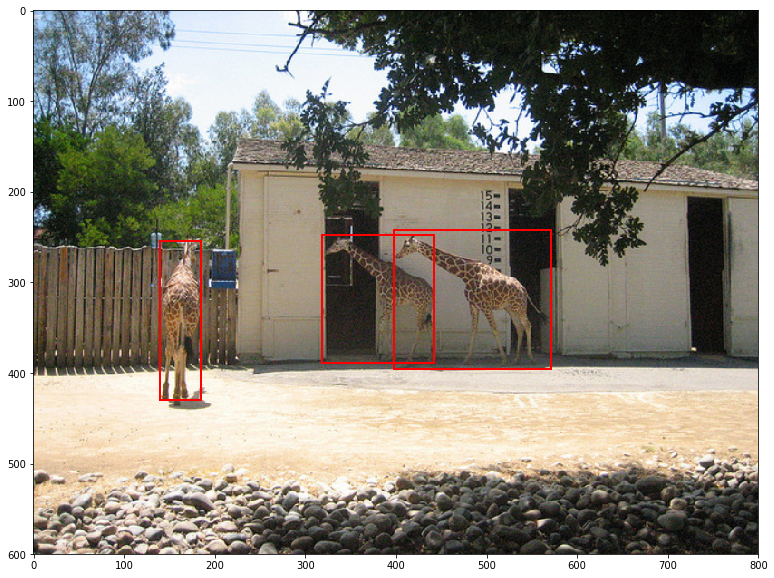

In [6]:
imshow(im[0], gt_boxes)

In [7]:
from faster_rcnn.faster_rcnn import  RPN

In [8]:
cc = CrayonClient(hostname="crayon", port=8889)
try:
    exp = cc.create_experiment("RPN")
except: 
    cc.remove_experiment("RPN")
    exp = cc.create_experiment("RPN")

disp_interval = 100
log_interval = 10

In [9]:
net = RPN()
net.cuda()
net.train()

RPN(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [ ]:
for submodel in net.features.children():
    for param in submodel.parameters():
        param.requires_grad = False

In [10]:
params = filter(lambda x: x.requires_grad, net.parameters())

In [11]:
optimizer = SGD(params, lr=0.001, momentum=0.9)

In [12]:
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.95)

In [13]:
def train(data_gen, optimizer, lr_scheduler, model, epoch):
    model.train()
    train_loss = 0
    losses = []
    for step in range(1, epoch):
        lr_scheduler.step()
        blobs = data_gen.next()
        if blobs is None:
            continue
        if step > epoch:
            break
        im_data = blobs['tensor']
        im_info = blobs['im_info']
        gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
        gt_ishard = blobs['gt_ishard']
        dontcare_areas = blobs['dontcare_areas']
        output = model(im_data, im_info, gt_boxes)
        loss = model.loss
        train_loss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        clip_gradient(model, 10.)
        optimizer.step()
        loss_value = loss.data.cpu().float()
        losses.append(loss_value)
        
        
        exp.add_scalar_value('current_loss', loss.data[0], step=step)

        if step % disp_interval == 0:

            log_text = 'step %d, image: %s, loss: %.4f' % (
                step, blobs['im_name'], train_loss /(step))
            print(log_text)

            re_cnt = True

        if step % log_interval == 0:
            exp.add_scalar_value('loss', train_loss /(step) , step=step)
            

In [14]:
train(t, optimizer, exp_lr_scheduler, net, 80000)

faster_rcnn/faster_rcnn.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rpn_cls_prob = F.softmax(rpn_cls_score_reshape)


step 100, image: COCO_train2014_000000393286.jpg, loss: 0.4619
step 200, image: COCO_train2014_000000152942.jpg, loss: 0.4072
step 300, image: COCO_train2014_000000096027.jpg, loss: 0.3701
step 400, image: COCO_train2014_000000000312.jpg, loss: 0.3426
step 500, image: COCO_train2014_000000262207.jpg, loss: 0.3216
step 600, image: COCO_train2014_000000000443.jpg, loss: 0.3058
step 700, image: COCO_train2014_000000000529.jpg, loss: 0.2963
step 800, image: COCO_train2014_000000000605.jpg, loss: 0.2871
step 900, image: COCO_train2014_000000131764.jpg, loss: 0.2800
step 1000, image: COCO_train2014_000000087507.jpg, loss: 0.2705
step 1100, image: COCO_train2014_000000262285.jpg, loss: 0.2704
step 1200, image: COCO_train2014_000000506315.jpg, loss: 0.2664
step 1300, image: COCO_train2014_000000394209.jpg, loss: 0.2652
step 1400, image: COCO_train2014_000000502620.jpg, loss: 0.2629
step 1500, image: COCO_train2014_000000394359.jpg, loss: 0.2579
step 1600, image: COCO_train2014_000000001224.jpg

step 12900, image: COCO_train2014_000000009833.jpg, loss: 0.2048
step 13000, image: COCO_train2014_000000504093.jpg, loss: 0.2046
step 13100, image: COCO_train2014_000000141056.jpg, loss: 0.2046
step 13200, image: COCO_train2014_000000403270.jpg, loss: 0.2046
step 13300, image: COCO_train2014_000000036729.jpg, loss: 0.2044
step 13400, image: COCO_train2014_000000220156.jpg, loss: 0.2043
step 13500, image: COCO_train2014_000000141352.jpg, loss: 0.2042
step 13600, image: COCO_train2014_000000403567.jpg, loss: 0.2043
step 13700, image: COCO_train2014_000000428071.jpg, loss: 0.2041
step 13800, image: COCO_train2014_000000272671.jpg, loss: 0.2039
step 13900, image: COCO_train2014_000000534892.jpg, loss: 0.2036
step 14000, image: COCO_train2014_000000534974.jpg, loss: 0.2035
step 14100, image: COCO_train2014_000000403966.jpg, loss: 0.2034
step 14200, image: COCO_train2014_000000395022.jpg, loss: 0.2032
step 14300, image: COCO_train2014_000000404127.jpg, loss: 0.2032
step 14400, image: COCO_t

step 25600, image: COCO_train2014_000000025102.jpg, loss: 0.1949
step 25700, image: COCO_train2014_000000281764.jpg, loss: 0.1948
step 25800, image: COCO_train2014_000000412910.jpg, loss: 0.1947
step 25900, image: COCO_train2014_000000332362.jpg, loss: 0.1946
step 26000, image: COCO_train2014_000000413070.jpg, loss: 0.1945
step 26100, image: COCO_train2014_000000151017.jpg, loss: 0.1945
step 26200, image: COCO_train2014_000000151096.jpg, loss: 0.1944
step 26300, image: COCO_train2014_000000282238.jpg, loss: 0.1943
step 26400, image: COCO_train2014_000000413382.jpg, loss: 0.1942
step 26500, image: COCO_train2014_000000282377.jpg, loss: 0.1942
step 26600, image: COCO_train2014_000000544601.jpg, loss: 0.1941
step 26700, image: COCO_train2014_000000106346.jpg, loss: 0.1940
step 26800, image: COCO_train2014_000000282603.jpg, loss: 0.1939
step 26900, image: COCO_train2014_000000151611.jpg, loss: 0.1938
step 27000, image: COCO_train2014_000000151678.jpg, loss: 0.1937
step 27100, image: COCO_t

step 38300, image: COCO_train2014_000000219196.jpg, loss: 0.1884
step 38400, image: COCO_train2014_000000553498.jpg, loss: 0.1884
step 38500, image: COCO_train2014_000000332562.jpg, loss: 0.1883
step 38600, image: COCO_train2014_000000160433.jpg, loss: 0.1882
step 38700, image: COCO_train2014_000000029426.jpg, loss: 0.1882
step 38800, image: COCO_train2014_000000550912.jpg, loss: 0.1882
step 38900, image: COCO_train2014_000000553872.jpg, loss: 0.1882
step 39000, image: COCO_train2014_000000422872.jpg, loss: 0.1881
step 39100, image: COCO_train2014_000000422960.jpg, loss: 0.1880
step 39200, image: COCO_train2014_000000160901.jpg, loss: 0.1879
step 39300, image: COCO_train2014_000000323970.jpg, loss: 0.1879
step 39400, image: COCO_train2014_000000161051.jpg, loss: 0.1879
step 39500, image: COCO_train2014_000000554333.jpg, loss: 0.1878
step 39600, image: COCO_train2014_000000161193.jpg, loss: 0.1878
step 39700, image: COCO_train2014_000000423412.jpg, loss: 0.1878
step 39800, image: COCO_t

step 51000, image: COCO_train2014_000000431977.jpg, loss: 0.1852
step 51100, image: COCO_train2014_000000300990.jpg, loss: 0.1851
step 51200, image: COCO_train2014_000000028333.jpg, loss: 0.1851
step 51300, image: COCO_train2014_000000432212.jpg, loss: 0.1850
step 51400, image: COCO_train2014_000000039064.jpg, loss: 0.1850
step 51500, image: COCO_train2014_000000552657.jpg, loss: 0.1850
step 51600, image: COCO_train2014_000000310140.jpg, loss: 0.1849
step 51700, image: COCO_train2014_000000394115.jpg, loss: 0.1849
step 51800, image: COCO_train2014_000000170464.jpg, loss: 0.1849
step 51900, image: COCO_train2014_000000301597.jpg, loss: 0.1848
step 52000, image: COCO_train2014_000000039520.jpg, loss: 0.1848
step 52100, image: COCO_train2014_000000421661.jpg, loss: 0.1848
step 52200, image: COCO_train2014_000000066789.jpg, loss: 0.1847
step 52300, image: COCO_train2014_000000170832.jpg, loss: 0.1846
step 52400, image: COCO_train2014_000000443547.jpg, loss: 0.1847
step 52500, image: COCO_t

step 63700, image: COCO_train2014_000000572749.jpg, loss: 0.1824
step 63800, image: COCO_train2014_000000310680.jpg, loss: 0.1824
step 63900, image: COCO_train2014_000000179687.jpg, loss: 0.1823
step 64000, image: COCO_train2014_000000441900.jpg, loss: 0.1823
step 64100, image: COCO_train2014_000000573046.jpg, loss: 0.1823
step 64200, image: COCO_train2014_000000198473.jpg, loss: 0.1823
step 64300, image: COCO_train2014_000000442133.jpg, loss: 0.1822
step 64400, image: COCO_train2014_000000442197.jpg, loss: 0.1822
step 64500, image: COCO_train2014_000000180129.jpg, loss: 0.1821
step 64600, image: COCO_train2014_000000442345.jpg, loss: 0.1821
step 64700, image: COCO_train2014_000000311361.jpg, loss: 0.1821
step 64800, image: COCO_train2014_000000442506.jpg, loss: 0.1821
step 64900, image: COCO_train2014_000000573659.jpg, loss: 0.1821
step 65000, image: COCO_train2014_000000488835.jpg, loss: 0.1821
step 65100, image: COCO_train2014_000000311644.jpg, loss: 0.1821
step 65200, image: COCO_t

step 76400, image: COCO_train2014_000000451364.jpg, loss: 0.1808
step 76500, image: COCO_train2014_000000189306.jpg, loss: 0.1808
step 76600, image: COCO_train2014_000000451529.jpg, loss: 0.1809
step 76700, image: COCO_train2014_000000058405.jpg, loss: 0.1808
step 76800, image: COCO_train2014_000000320643.jpg, loss: 0.1808
step 76900, image: COCO_train2014_000000503871.jpg, loss: 0.1808
step 77000, image: COCO_train2014_000000206387.jpg, loss: 0.1808
step 77100, image: COCO_train2014_000000189838.jpg, loss: 0.1808
step 77200, image: COCO_train2014_000000569347.jpg, loss: 0.1808
step 77300, image: COCO_train2014_000000321066.jpg, loss: 0.1807
step 77400, image: COCO_train2014_000000190086.jpg, loss: 0.1807
step 77500, image: COCO_train2014_000000097229.jpg, loss: 0.1808
step 77600, image: COCO_train2014_000000162753.jpg, loss: 0.1808
step 77700, image: COCO_train2014_000000190322.jpg, loss: 0.1808
step 77800, image: COCO_train2014_000000058714.jpg, loss: 0.1808
step 77900, image: COCO_t

In [ ]:
t.next()

In [16]:
torch.save(net.state_dict(), 'rpn.pkl')

In [ ]:
net.load_state_dict(torch.load('./rpn3.pkl'))


In [17]:
blobs =  cap[13499]
im_data = blobs['tensor']
im_info = blobs['im_info']
gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])

print gt_boxes.shape

print blobs['boxes'] 
print blobs['image_info']
origin_gt_box =  blobs['boxes']
print origin_gt_box.shape

(3, 5)
[[ 140.    253.75  185.    430.  ]
 [ 318.75  247.5   442.5   388.75]
 [ 397.5   242.5   571.25  395.  ]]
{u'license': 1, u'file_name': u'COCO_train2014_000000309241.jpg', u'coco_url': u'http://mscoco.org/images/309241', u'height': 480, u'width': 640, u'date_captured': u'2013-11-16 12:01:50', u'flickr_url': u'http://farm2.staticflickr.com/1241/992106560_15b6dd2b92_z.jpg', u'id': 309241}
(3, 4)


In [30]:
box_data = net.predict(im_data, im_info)

In [31]:
_allowed_border = 0
all_anchors = box_data
inds_inside = np.where(
    (all_anchors[:, 0] >= -_allowed_border) &
    (all_anchors[:, 1] >= -_allowed_border) &
    (all_anchors[:, 2] < im_info[0][1] + _allowed_border) &  # width
    (all_anchors[:, 3] < im_info[0][0] + _allowed_border)  # height
)[0]

print inds_inside

[   48    53    60 ..., 22136 22148 22184]


In [32]:
box_data = box_data[inds_inside]

In [33]:
from faster_rcnn.utils.cython_bbox import bbox_overlaps

print origin_gt_box[:3].shape

overlaps = bbox_overlaps(
    np.ascontiguousarray(box_data, dtype=np.float),
    np.ascontiguousarray(origin_gt_box, dtype=np.float))

argmax_overlaps = overlaps.argmax(axis=0)  # (A)
print overlaps.max(axis=0)
print argmax_overlaps

(3, 4)
[ 0.63120703  0.85006188  0.83075233]
[6361 5852 5186]


In [34]:
sorted_overlap = np.argsort(overlaps, axis=1)
print sorted_overlap.shape
best_overlap_boxes =  sorted_overlap[-3:].flatten()
gt_argmax_overlaps = overlaps.argmax(axis=0)  # G
gt_max_overlaps = overlaps[gt_argmax_overlaps,
                           np.arange(overlaps.shape[1])]
print gt_max_overlaps
print gt_argmax_overlaps

(9761, 3)
[ 0.63120703  0.85006188  0.83075233]
[6361 5852 5186]


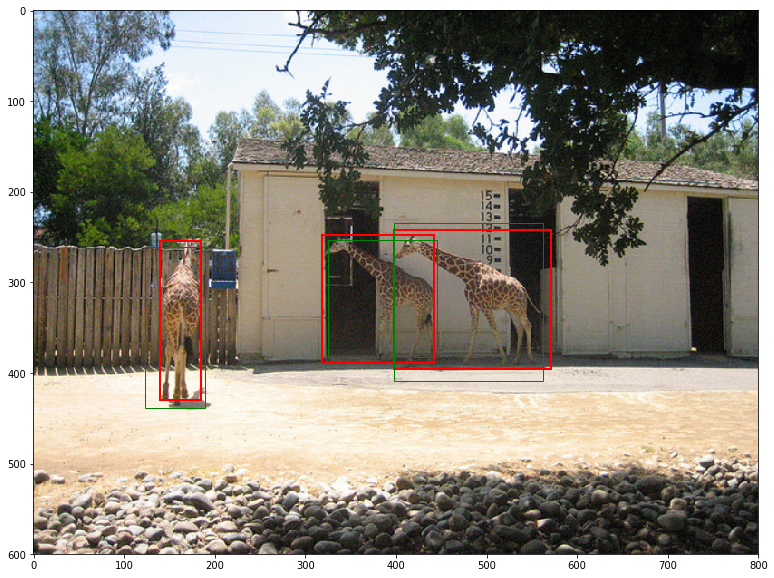

In [35]:
imshow(blobs['tensor'][0], gt_boxes, box_data[gt_argmax_overlaps])